In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/newparticulate_covidstat.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wso2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wpm10_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wso2_period1_2020,"+\
        "avg_wno_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = in_datapaper
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   monza
   2   lodi
   3   lecce
   4   massa
   5   frosinone
   6   asti
   7   trieste
   8   roma
   9   enna
   10   bari
   11   alessandria
   12   latina
   13   mantova
   14   bat
   15   genova
   16   pordenone
   17   isernia
   18   taranto
   19   vibo_valentia
   20   forli
   21   cosenza
   22   trapani
   23   fermo
   24   bologna
   25   reggio_di_calabria
   26   terni
   27   firenze
   28   piacenza
   29   messina
   30   treviso
   31   gorizia
   32   viterbo
   33   rieti
   34   pisa
   35   vicenza
   36   grosseto
   37   foggia
   38   macerata
   39   campobasso
   40   catanzaro
   41   reggio_nell_emilia
   42   modena
   43   nuoro
   44   sassari
   45   cagliari
   46   lucca
   47   cremona
   48   brindisi
   49   avellino
   50   trento
   51   ferrara
   52   palermo
   53   arezzo
   54   como
   55   cuneo
   56   siracusa
   57   venezia
   58   livorno
   59   pe

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 monza
2 lodi
3 lecce
4 massa
5 frosinone
6 asti
7 trieste
8 roma
9 enna
10 bari
11 alessandria
12 latina
13 mantova
14 bat
15 genova
16 pordenone
17 taranto
18 vibo_valentia
19 forli
20 cosenza
21 trapani
22 fermo
23 bologna
24 reggio_di_calabria
25 terni
26 firenze
27 piacenza
28 messina
29 treviso
30 gorizia
31 viterbo
32 rieti
33 pisa
34 vicenza
35 grosseto
36 foggia
37 macerata
38 campobasso
39 catanzaro
40 reggio_nell_emilia
41 modena
42 nuoro
43 sassari
44 cagliari
45 lucca
46 cremona
47 brindisi
48 avellino
49 trento
50 ferrara
51 palermo
52 arezzo
53 como
54 cuneo
55 siracusa
56 venezia
57 livorno
58 perugia
59 teramo
60 chieti
61 bolzano
62 belluno
63 sondrio
64 bergamo
65 catania
66 ragusa
67 salerno
68 brescia
69 varese
70 potenza
71 caserta
72 la_spezia
73 pescara
74 verbania
75 pistoia
76 siena
77 agrigento
78 pesaro
79 parma
80 napoli
81 imperia
82 vercelli
83 milano
84 ravenna
85 padova
86 rovigo
87 pavia
88 ancona
89 savona
90 biella
91 ascoli_piceno
92 novara
93 udin

In [4]:
#add random feature
import random

#featurestobeused += ",randomfeature"
#features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

#random.seed(1)
#for i in range(len(ylogpropcasi)):
#    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Using:                        density
Using:               commutersdensity
Using:                         depriv
Using:                            lat
Using:                 Ratio0200ver65
Using:         avg_wpm10_period1_2020
Using:          avg_wso2_period1_2020
Using:           avg_wno_period1_2020

 


In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

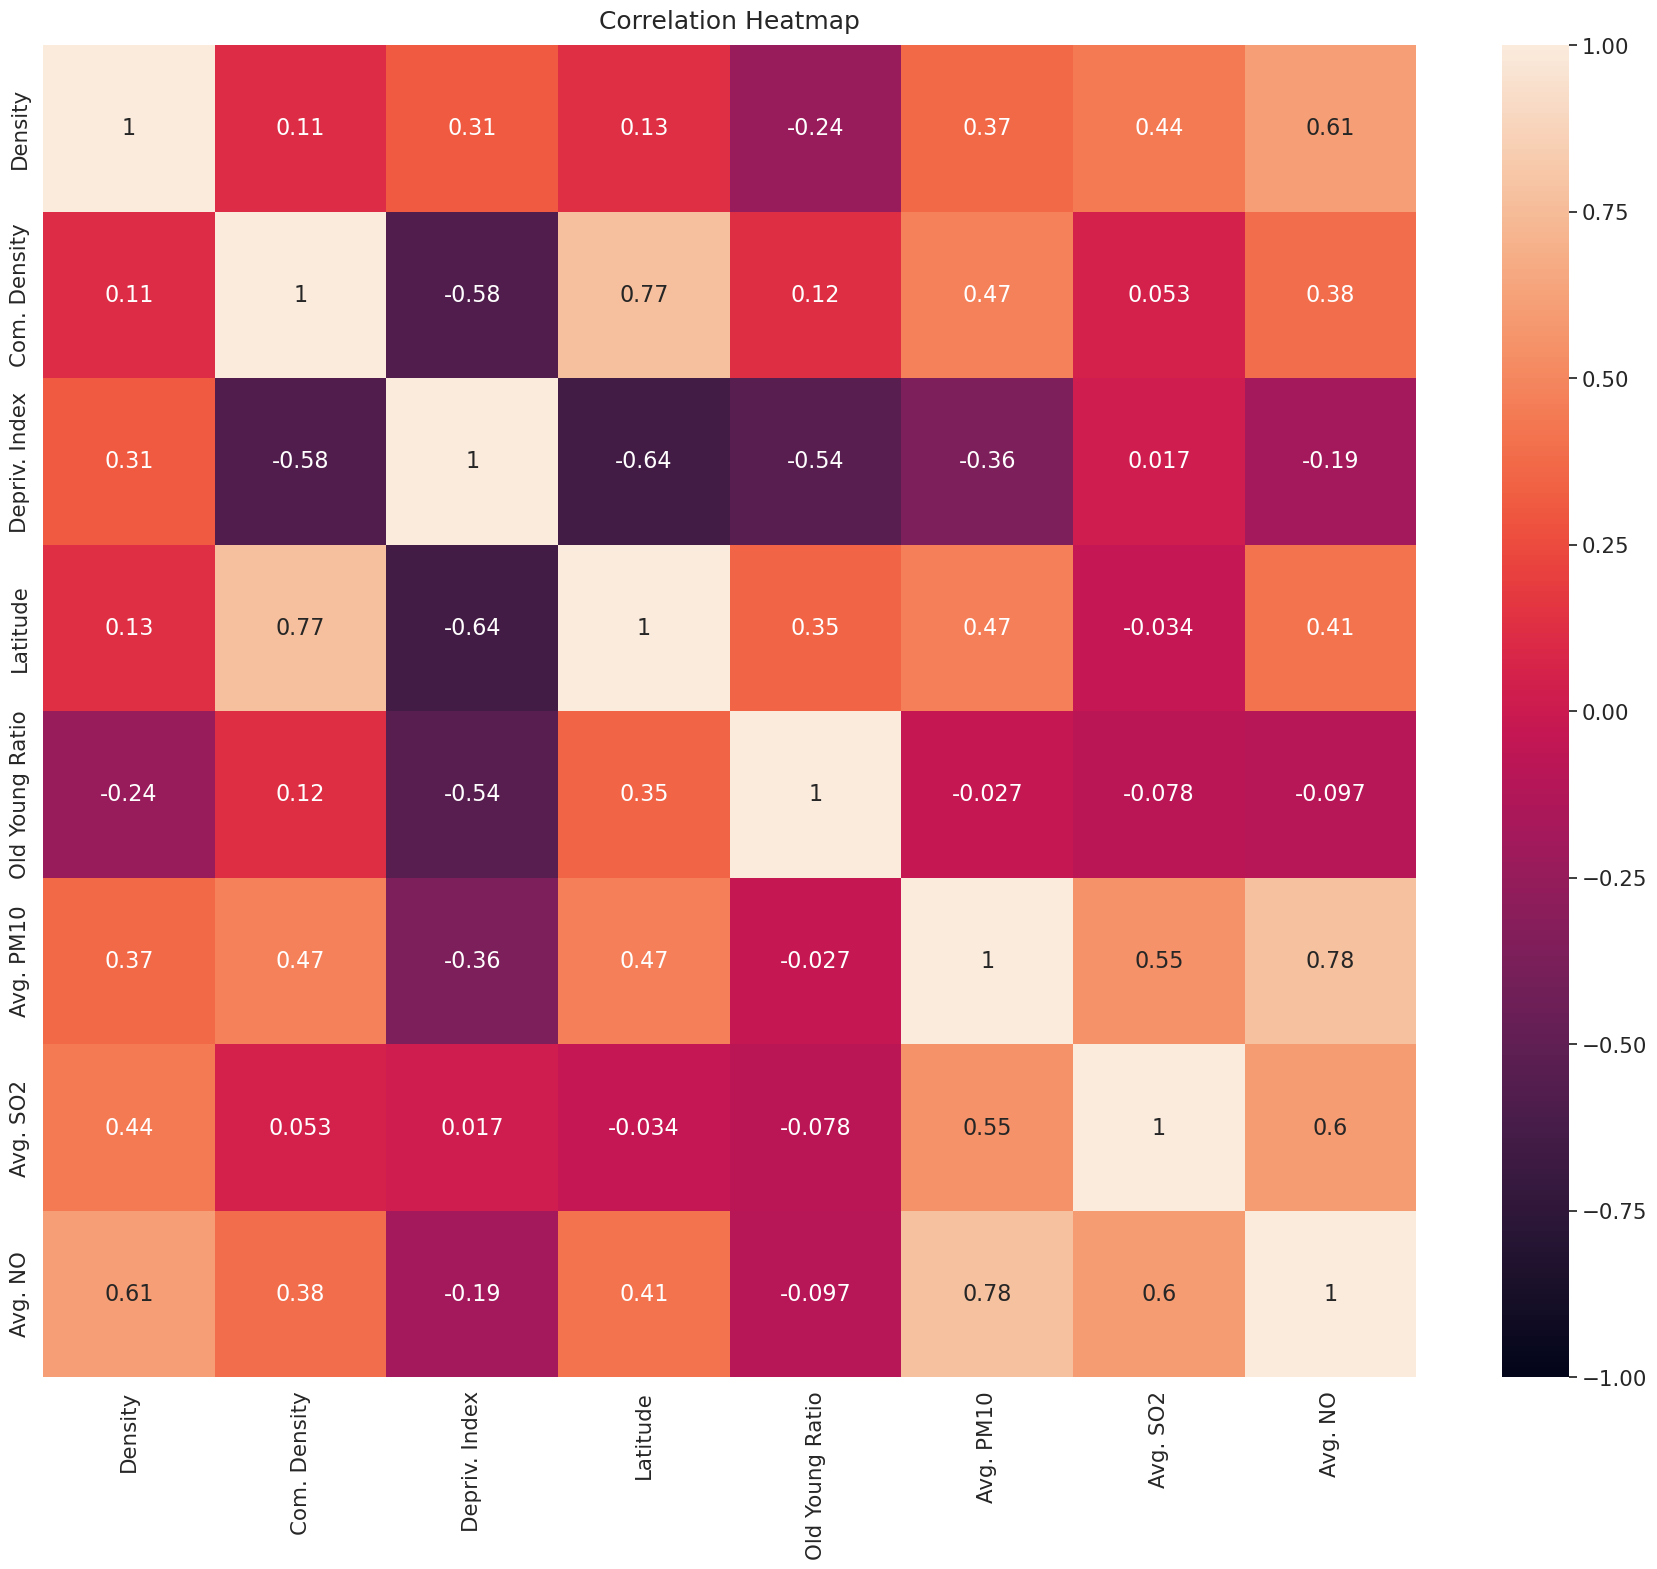

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.33727  0.02351 
    Test set average RMSE:  0.91444  0.10610 

Prediction STD :    1.25507
True value STD :    1.43281
Difference in percentage:   12.40496

             Fullset RMSE:    0.31975
                       R2:    0.95020


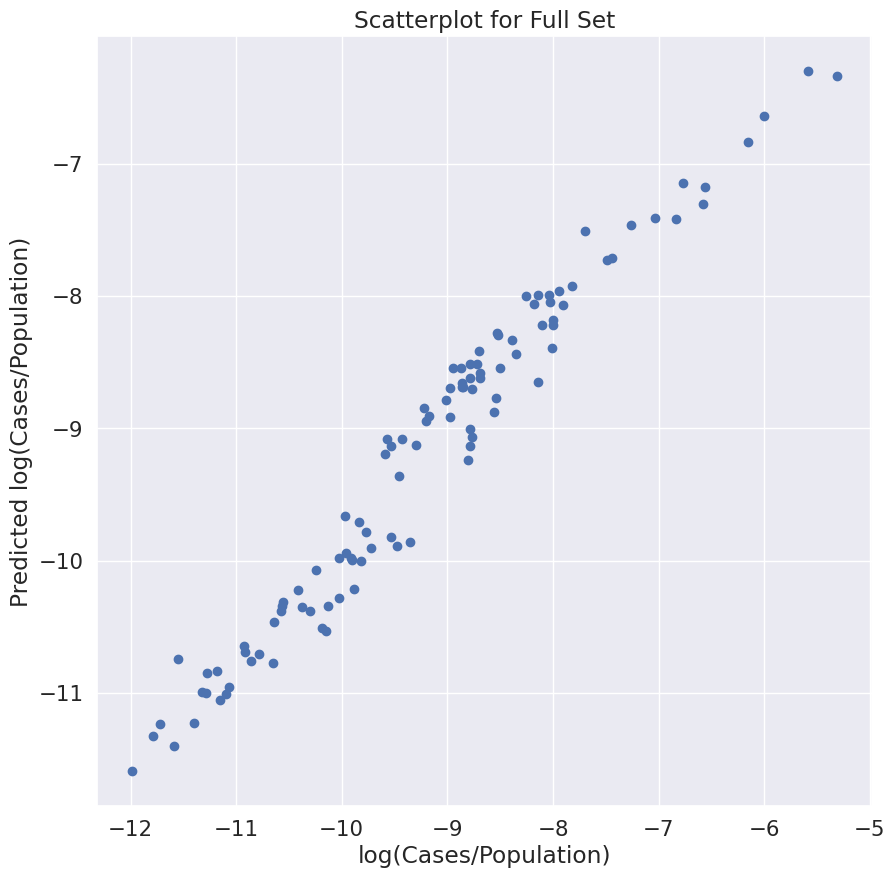

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06880 +/- 0.00744
Feature:                   Com. Density, Score: 0.24827 +/- 0.03451
Feature:                  Depriv. Index, Score: 0.17377 +/- 0.02365
Feature:                       Latitude, Score: 0.72787 +/- 0.08959
Feature:                Old Young Ratio, Score: 0.13199 +/- 0.01765
Feature:                      Avg. PM10, Score: 0.20843 +/- 0.02232
Feature:                       Avg. SO2, Score: 0.10867 +/- 0.01201
Feature:                        Avg. NO, Score: 0.22572 +/- 0.02587


<Figure size 640x480 with 0 Axes>

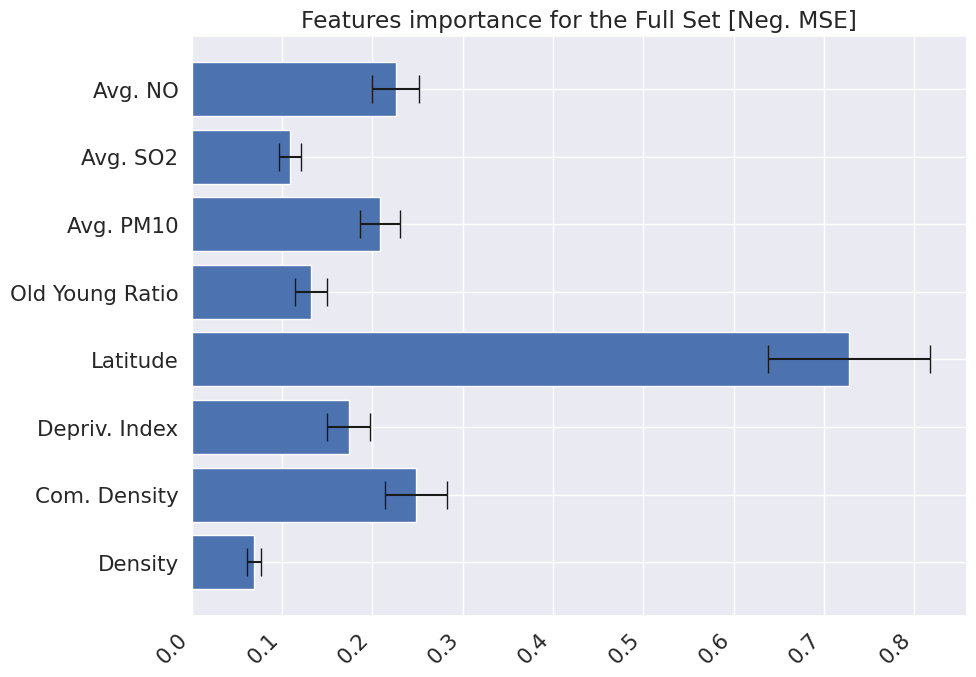

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.03352 +/- 0.00362
Feature:                   Com. Density, Score: 0.12094 +/- 0.01681
Feature:                  Depriv. Index, Score: 0.08464 +/- 0.01152
Feature:                       Latitude, Score: 0.35455 +/- 0.04364
Feature:                Old Young Ratio, Score: 0.06429 +/- 0.00860
Feature:                      Avg. PM10, Score: 0.10153 +/- 0.01087
Feature:                       Avg. SO2, Score: 0.05294 +/- 0.00585
Feature:                        Avg. NO, Score: 0.10995 +/- 0.01260


<Figure size 640x480 with 0 Axes>

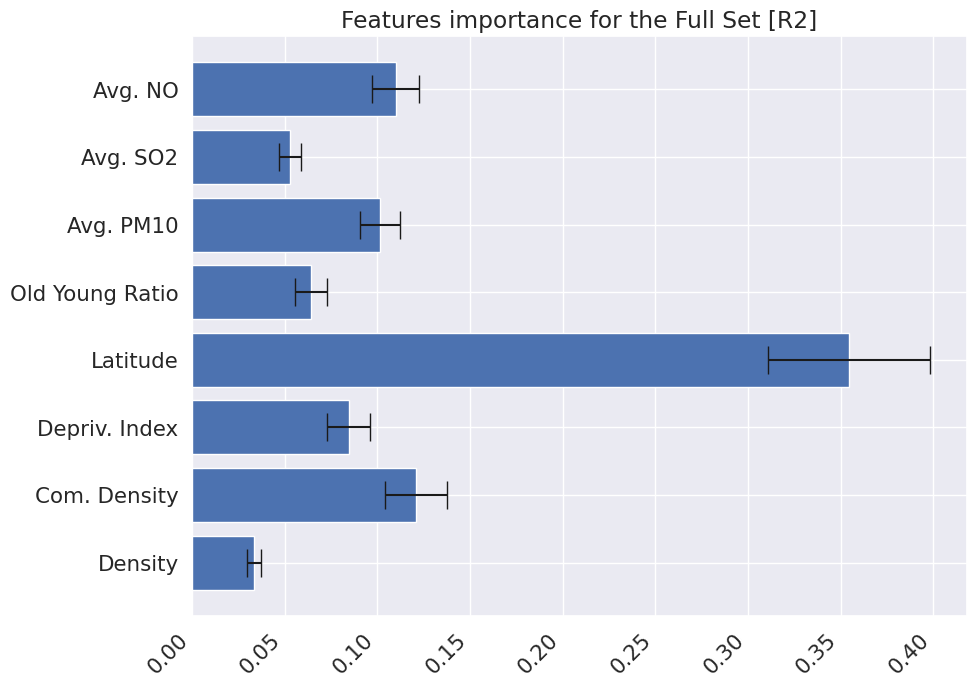

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.35211
                       R2:    0.94716


<Figure size 640x480 with 0 Axes>

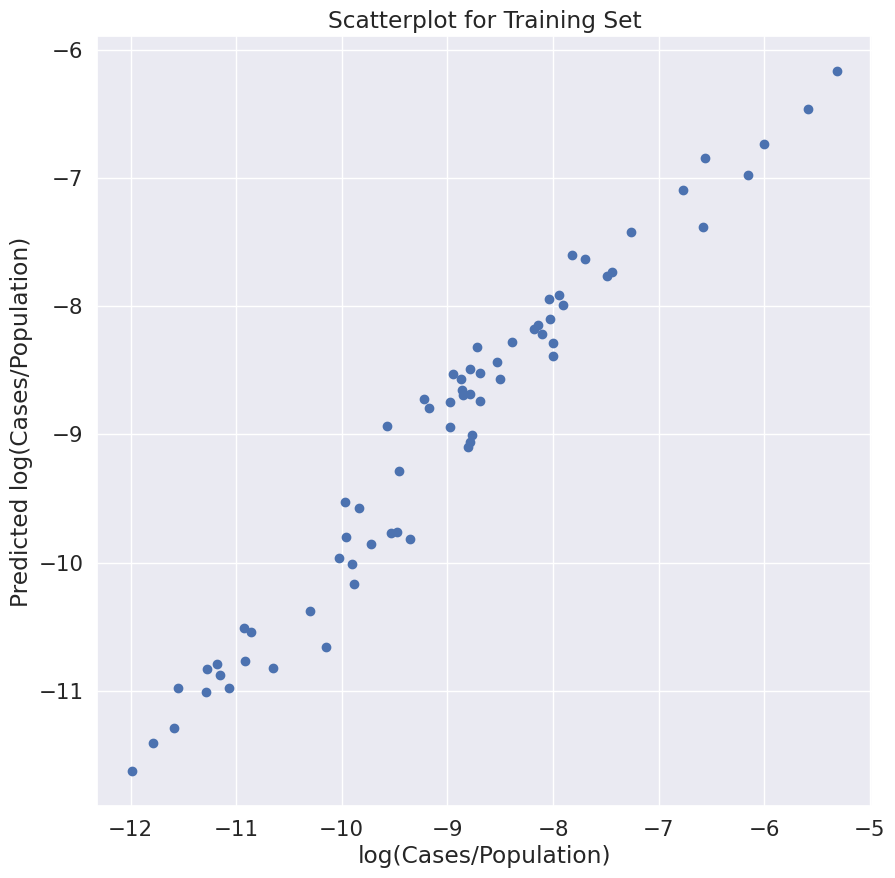

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    0.79325
                       R2:    0.53126


<Figure size 640x480 with 0 Axes>

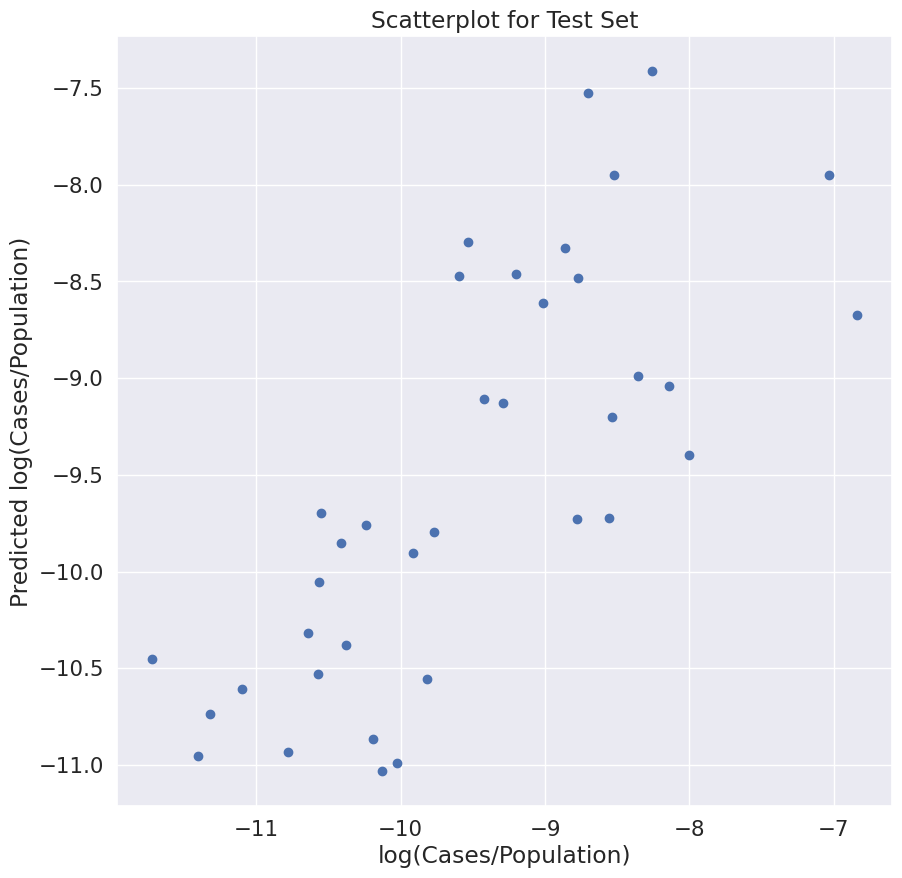

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00268 +/- 0.02135
Feature:                   Com. Density, Score: 0.05202 +/- 0.05724
Feature:                  Depriv. Index, Score: 0.00094 +/- 0.03559
Feature:                       Latitude, Score: 0.47672 +/- 0.12512


<Figure size 640x480 with 0 Axes>

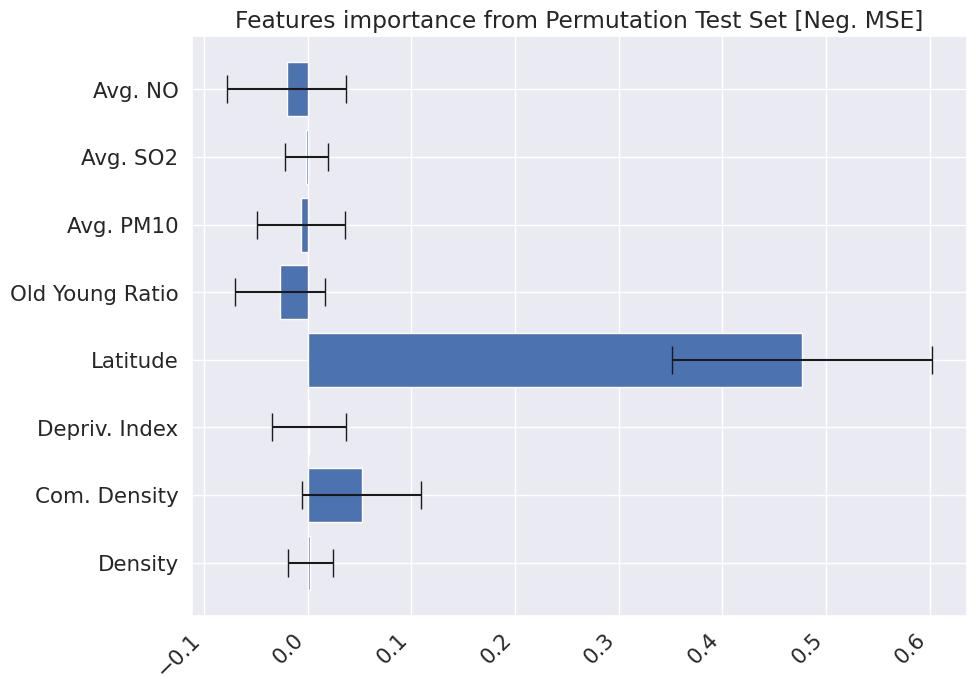

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00200 +/- 0.01591
Feature:                   Com. Density, Score: 0.03875 +/- 0.04264
Feature:                  Depriv. Index, Score: 0.00070 +/- 0.02651
Feature:                       Latitude, Score: 0.35512 +/- 0.09320


<Figure size 640x480 with 0 Axes>

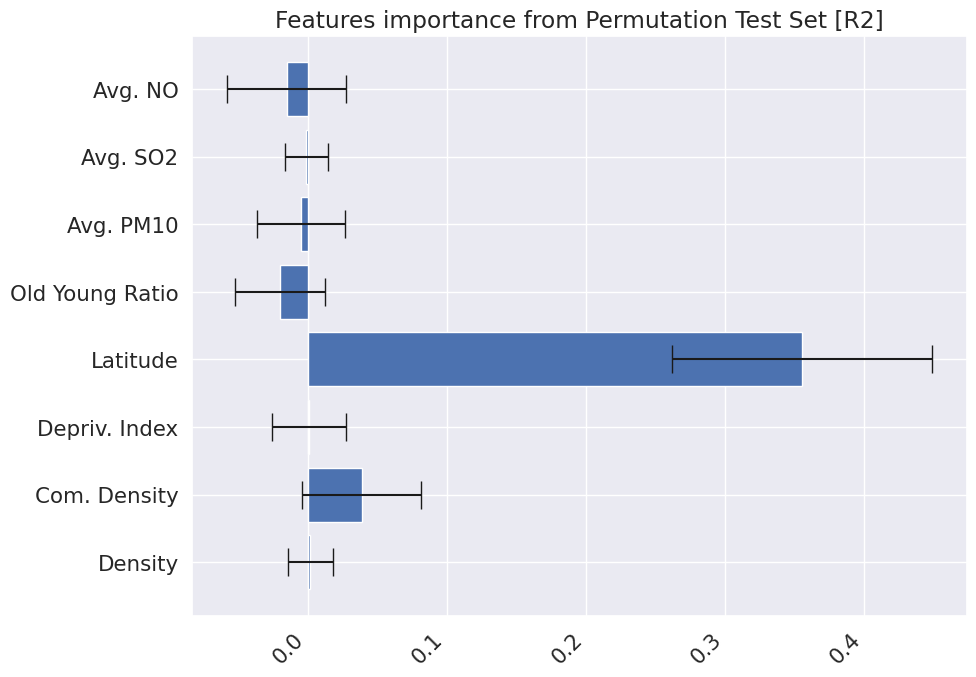

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.08987 +/- 0.01270
Feature:                   Com. Density, Score: 0.22160 +/- 0.03589
Feature:                  Depriv. Index, Score: 0.16302 +/- 0.02738
Feature:                       Latitude, Score: 0.73431 +/- 0.11712
Feature:                Old Young Ratio, Score: 0.14147 +/- 0.02140
Feature:                      Avg. PM10, Score: 0.26539 +/- 0.04007
Feature:                       Avg. SO2, Score: 0.09585 +/- 0.01374
Feature:                        Avg. NO, Score: 0.25924 +/- 0.03732


<Figure size 640x480 with 0 Axes>

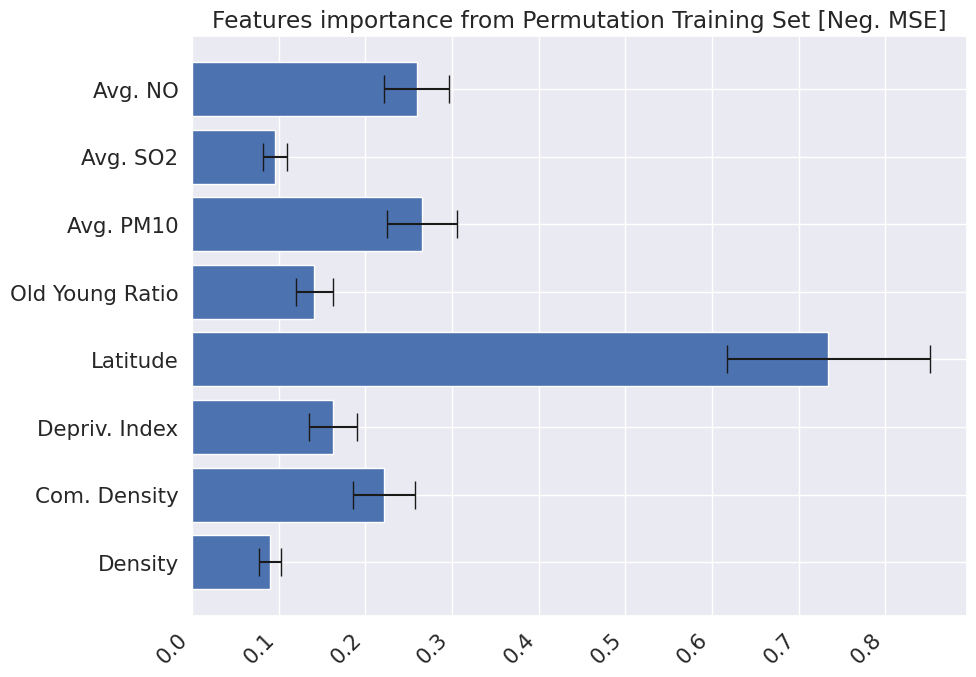

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.03830 +/- 0.00541
Feature:                   Com. Density, Score: 0.09445 +/- 0.01530
Feature:                  Depriv. Index, Score: 0.06949 +/- 0.01167
Feature:                       Latitude, Score: 0.31299 +/- 0.04992
Feature:                Old Young Ratio, Score: 0.06030 +/- 0.00912
Feature:                      Avg. PM10, Score: 0.11312 +/- 0.01708
Feature:                       Avg. SO2, Score: 0.04086 +/- 0.00586
Feature:                        Avg. NO, Score: 0.11050 +/- 0.01591


<Figure size 640x480 with 0 Axes>

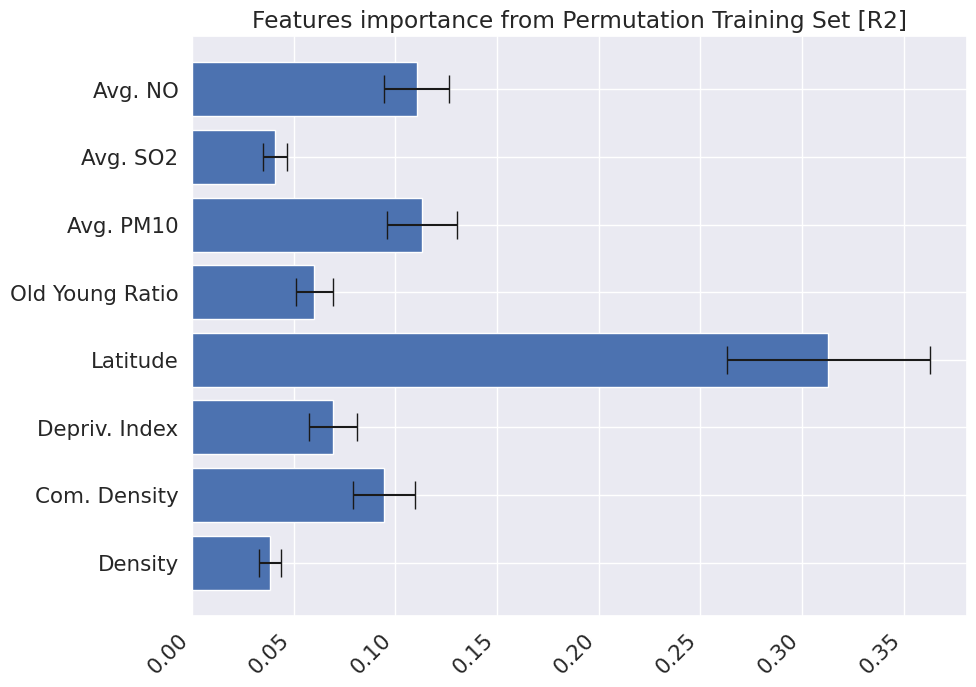

<Figure size 1000x1000 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36124  0.02114 
    Test set average RMSE:  0.98978  0.10103 

Prediction STD :    1.23935
True value STD :    1.43281
Difference in percentage:   13.50196

             Fullset RMSE:    0.34126
                       R2:    0.94327


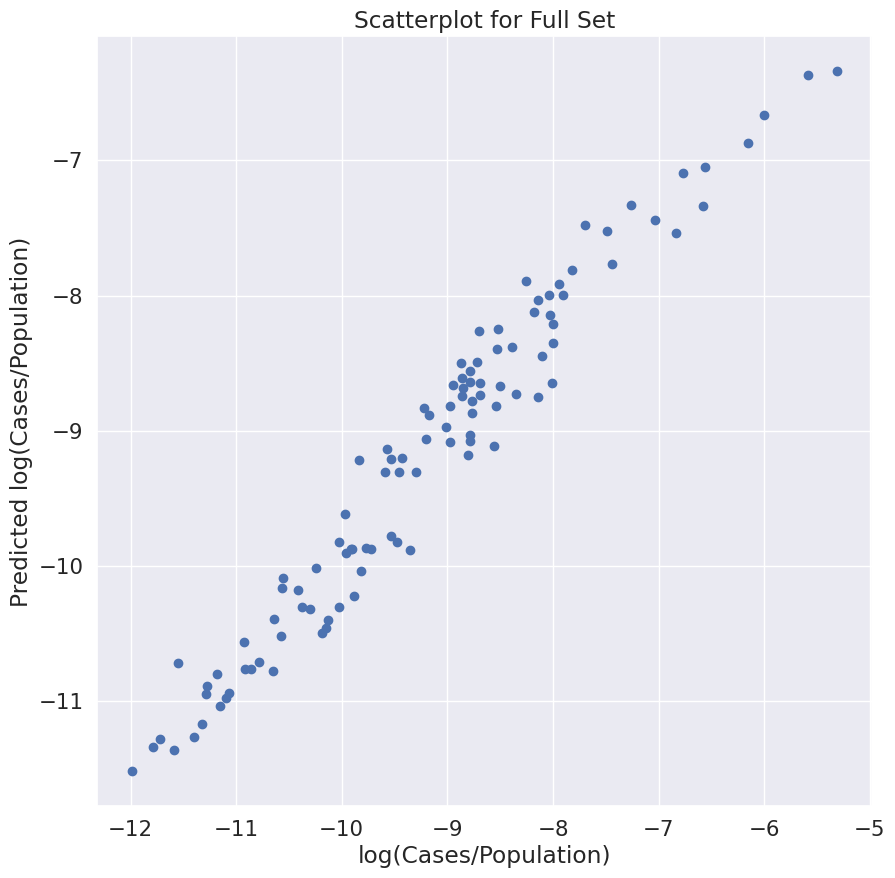

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.10172 +/- 0.01078
Feature:                   Com. Density, Score: 0.68748 +/- 0.08883
Feature:                  Depriv. Index, Score: 0.23133 +/- 0.03454
Feature:                Old Young Ratio, Score: 0.15403 +/- 0.01836
Feature:                      Avg. PM10, Score: 0.29898 +/- 0.03201
Feature:                       Avg. SO2, Score: 0.17419 +/- 0.02115
Feature:                        Avg. NO, Score: 0.38856 +/- 0.04451


<Figure size 640x480 with 0 Axes>

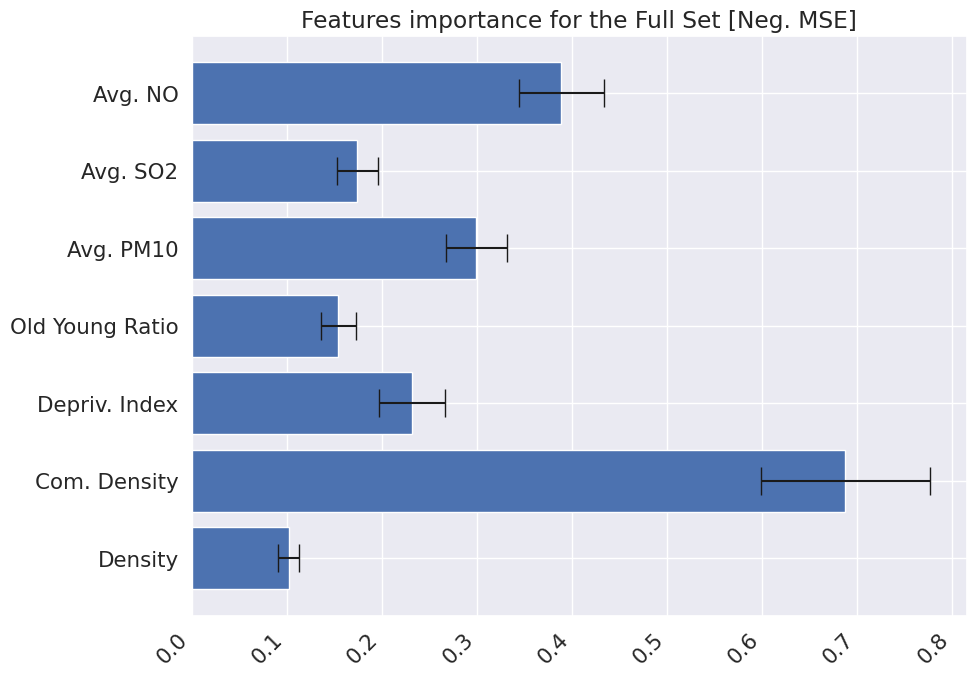

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.04955 +/- 0.00525
Feature:                   Com. Density, Score: 0.33487 +/- 0.04327
Feature:                  Depriv. Index, Score: 0.11268 +/- 0.01683
Feature:                Old Young Ratio, Score: 0.07503 +/- 0.00894
Feature:                      Avg. PM10, Score: 0.14564 +/- 0.01559
Feature:                       Avg. SO2, Score: 0.08485 +/- 0.01030
Feature:                        Avg. NO, Score: 0.18927 +/- 0.02168


<Figure size 640x480 with 0 Axes>

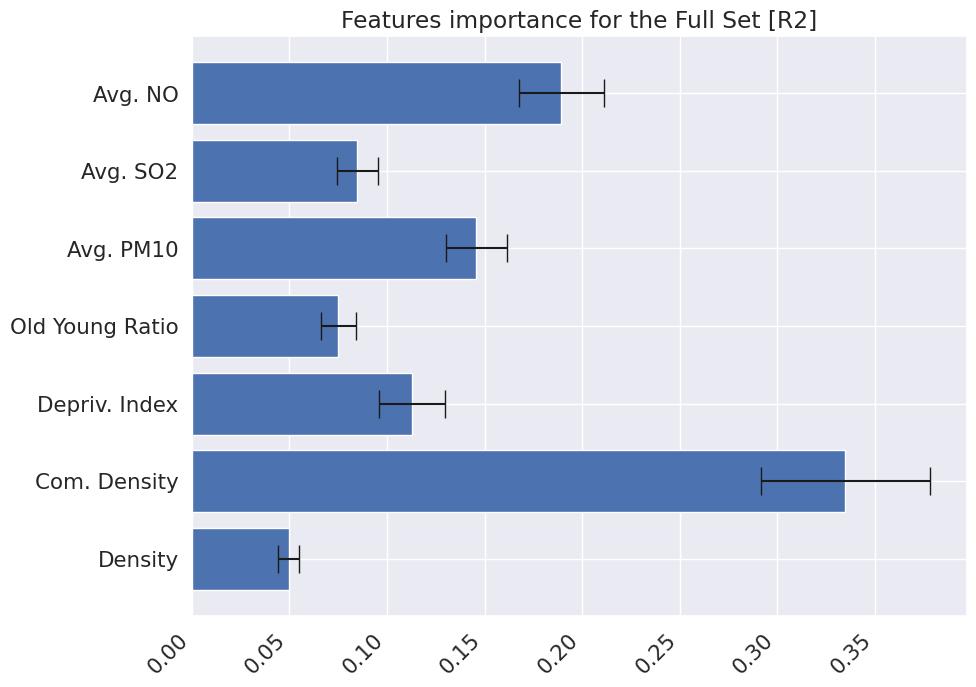

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.37856
                       R2:    0.93445


<Figure size 640x480 with 0 Axes>

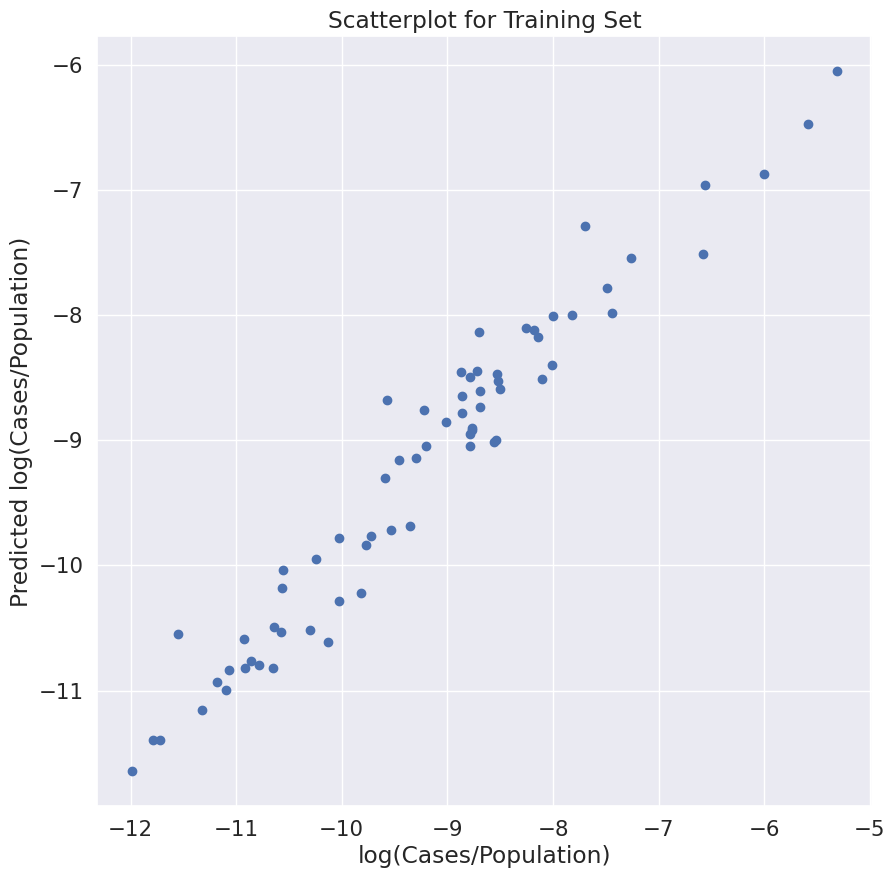

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    0.83831
                       R2:    0.61200


<Figure size 640x480 with 0 Axes>

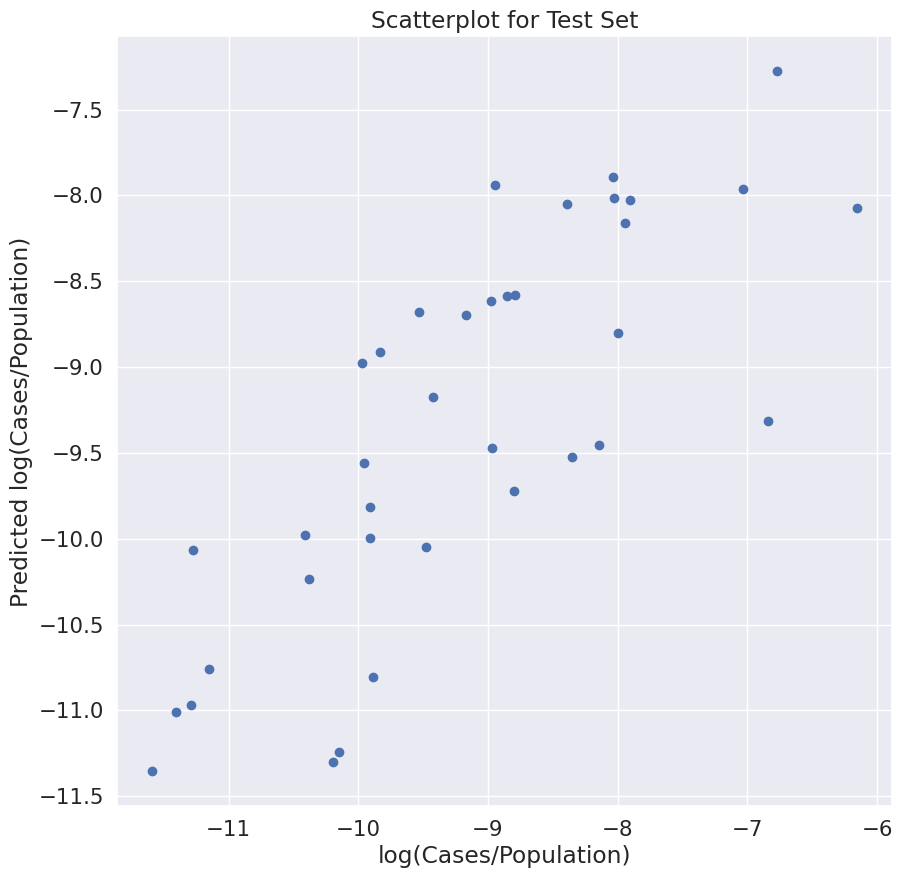

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.04769 +/- 0.02329
Feature:                   Com. Density, Score: 0.36306 +/- 0.13314
Feature:                  Depriv. Index, Score: 0.11023 +/- 0.09018
Feature:                Old Young Ratio, Score: 0.01481 +/- 0.04053
Feature:                      Avg. PM10, Score: 0.04167 +/- 0.06335
Feature:                       Avg. SO2, Score: 0.06834 +/- 0.02571
Feature:                        Avg. NO, Score: 0.12392 +/- 0.09445


<Figure size 640x480 with 0 Axes>

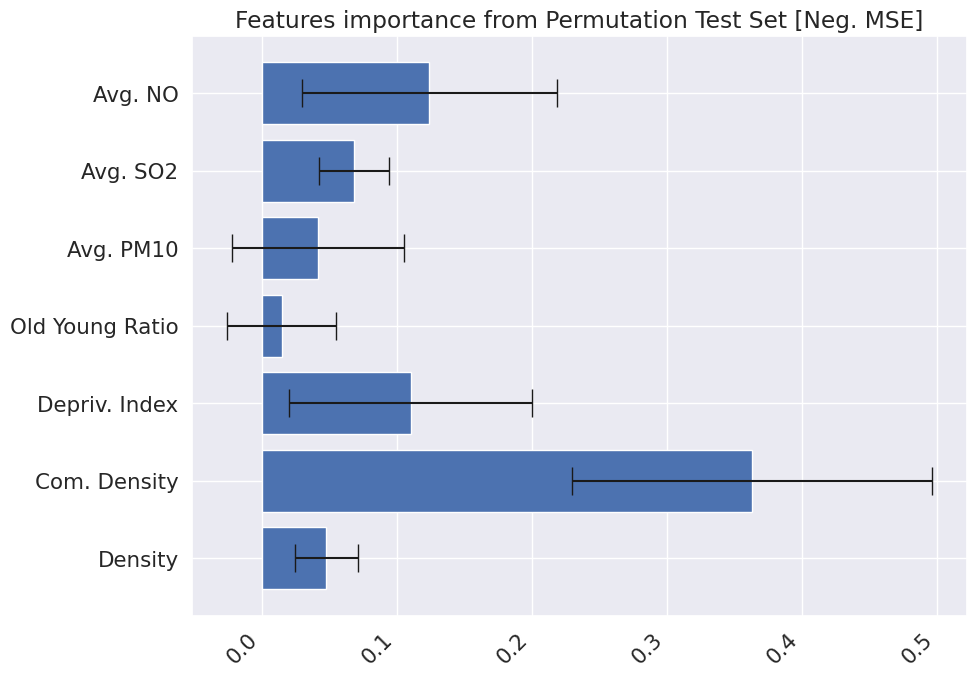

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.02633 +/- 0.01286
Feature:                   Com. Density, Score: 0.20044 +/- 0.07351
Feature:                  Depriv. Index, Score: 0.06086 +/- 0.04979
Feature:                Old Young Ratio, Score: 0.00818 +/- 0.02237
Feature:                      Avg. PM10, Score: 0.02301 +/- 0.03498
Feature:                       Avg. SO2, Score: 0.03773 +/- 0.01419
Feature:                        Avg. NO, Score: 0.06841 +/- 0.05215


<Figure size 640x480 with 0 Axes>

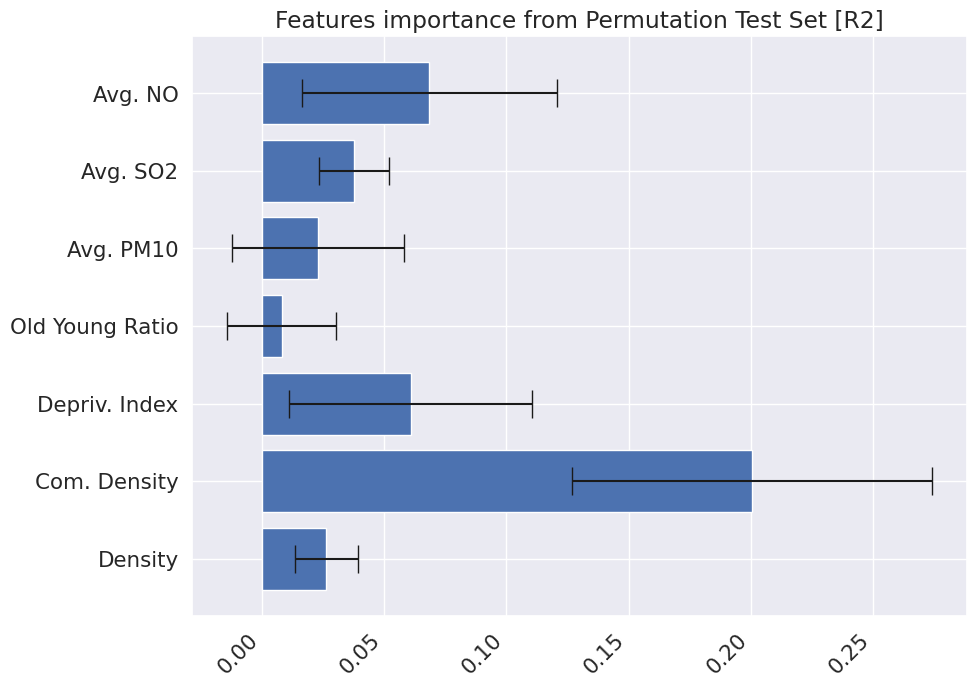

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.07740 +/- 0.00985
Feature:                   Com. Density, Score: 0.49543 +/- 0.09874
Feature:                  Depriv. Index, Score: 0.33996 +/- 0.06862
Feature:                Old Young Ratio, Score: 0.18206 +/- 0.03087
Feature:                      Avg. PM10, Score: 0.29434 +/- 0.05689
Feature:                       Avg. SO2, Score: 0.13424 +/- 0.01891
Feature:                        Avg. NO, Score: 0.33411 +/- 0.05174


<Figure size 640x480 with 0 Axes>

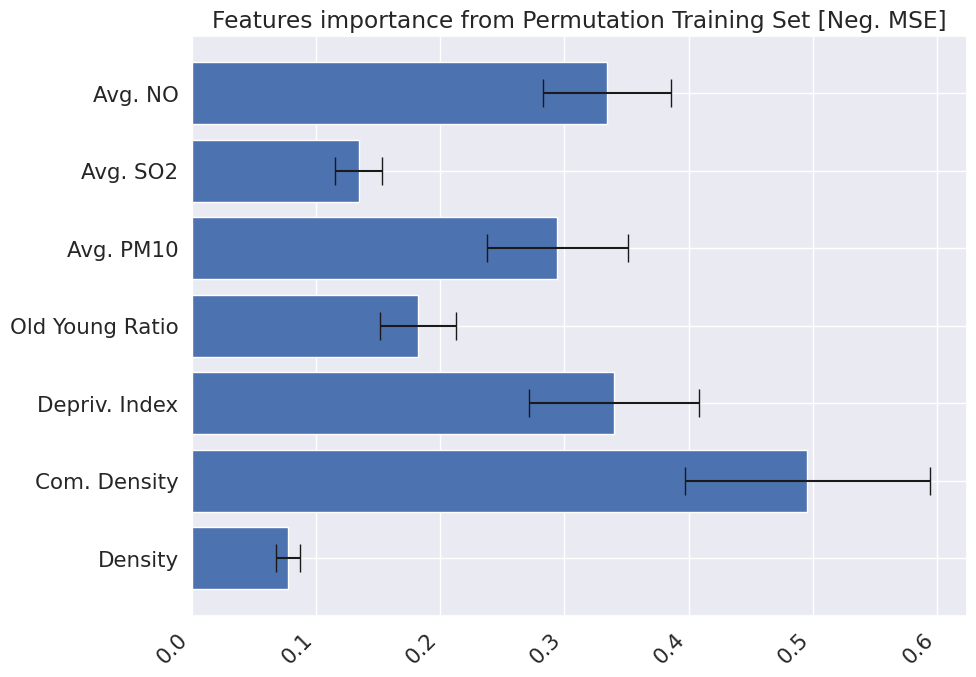

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.03540 +/- 0.00450
Feature:                   Com. Density, Score: 0.22661 +/- 0.04516
Feature:                  Depriv. Index, Score: 0.15550 +/- 0.03139
Feature:                Old Young Ratio, Score: 0.08328 +/- 0.01412
Feature:                      Avg. PM10, Score: 0.13463 +/- 0.02602
Feature:                       Avg. SO2, Score: 0.06140 +/- 0.00865
Feature:                        Avg. NO, Score: 0.15282 +/- 0.02367


<Figure size 640x480 with 0 Axes>

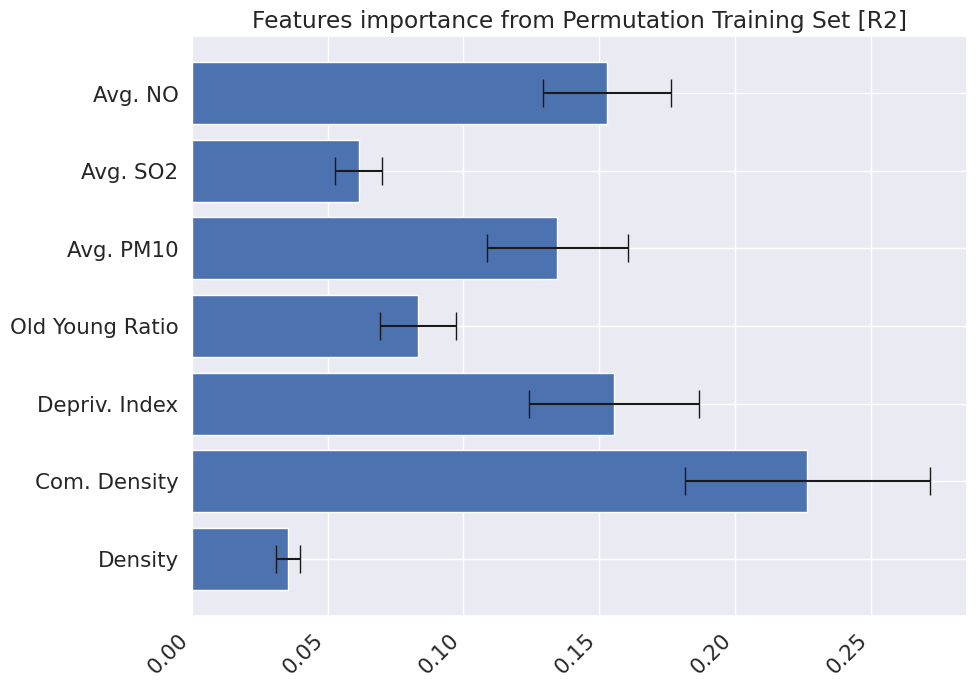

<Figure size 1000x1000 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37949  0.02541 
    Test set average RMSE:  1.00953  0.10165 

Prediction STD :    1.20781
True value STD :    1.43281
Difference in percentage:   15.70347

             Fullset RMSE:    0.36248
                       R2:    0.93600


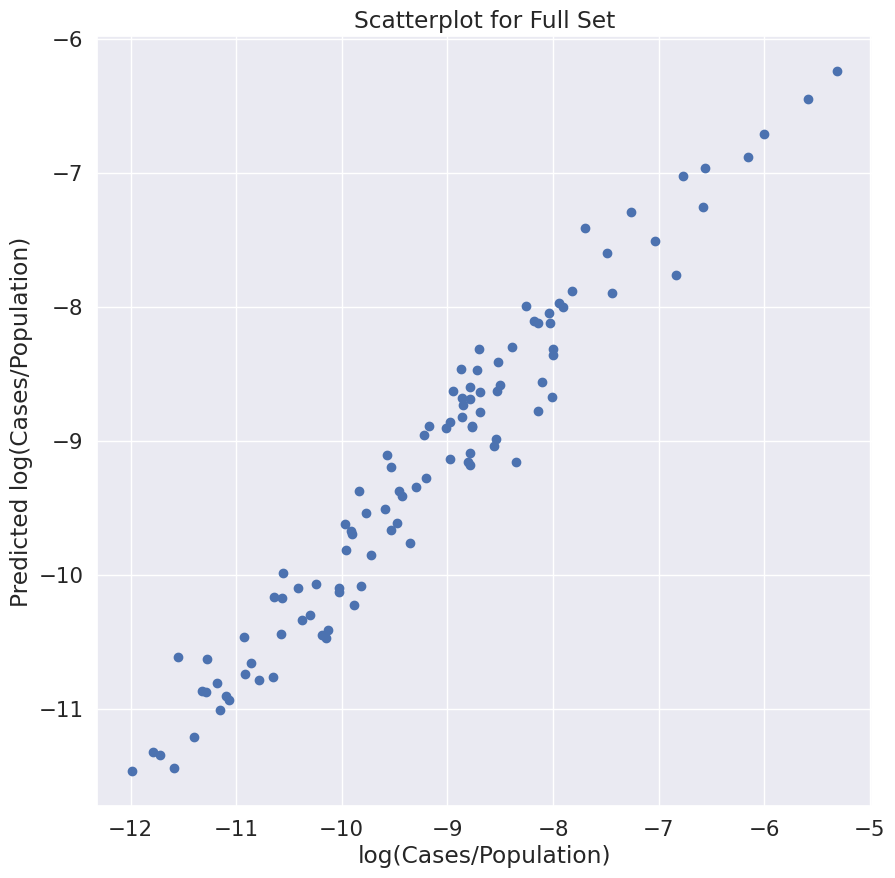

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12645 +/- 0.01179
Feature:                  Depriv. Index, Score: 0.57371 +/- 0.08741
Feature:                Old Young Ratio, Score: 0.20225 +/- 0.02207
Feature:                      Avg. PM10, Score: 0.48235 +/- 0.05457
Feature:                       Avg. SO2, Score: 0.21216 +/- 0.02104
Feature:                        Avg. NO, Score: 0.61288 +/- 0.07561


<Figure size 640x480 with 0 Axes>

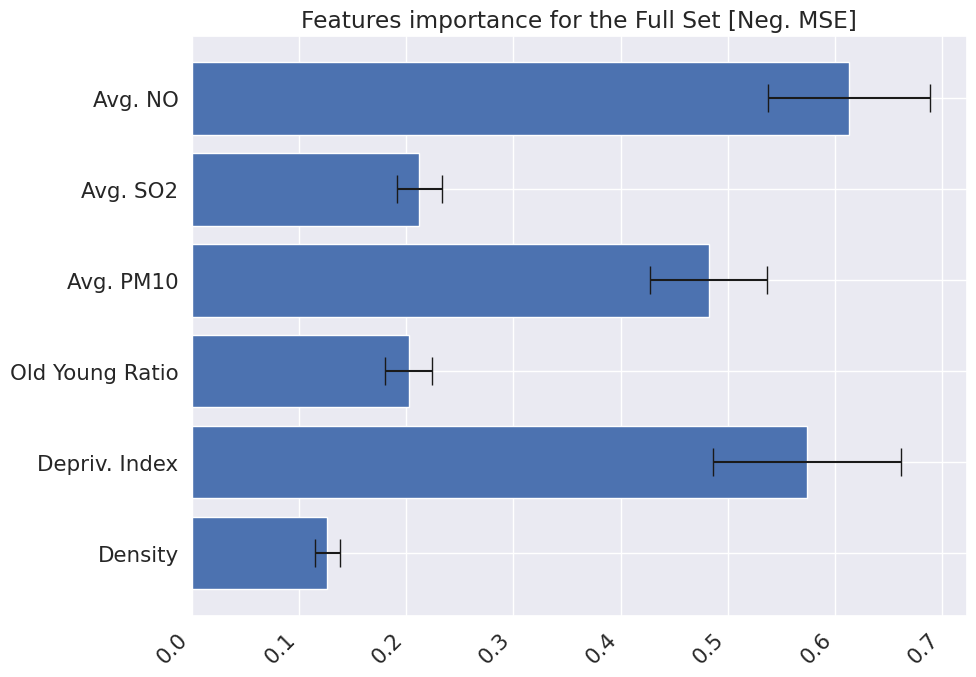

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06159 +/- 0.00575
Feature:                  Depriv. Index, Score: 0.27946 +/- 0.04258
Feature:                Old Young Ratio, Score: 0.09852 +/- 0.01075
Feature:                      Avg. PM10, Score: 0.23496 +/- 0.02658
Feature:                       Avg. SO2, Score: 0.10335 +/- 0.01025
Feature:                        Avg. NO, Score: 0.29854 +/- 0.03683


<Figure size 640x480 with 0 Axes>

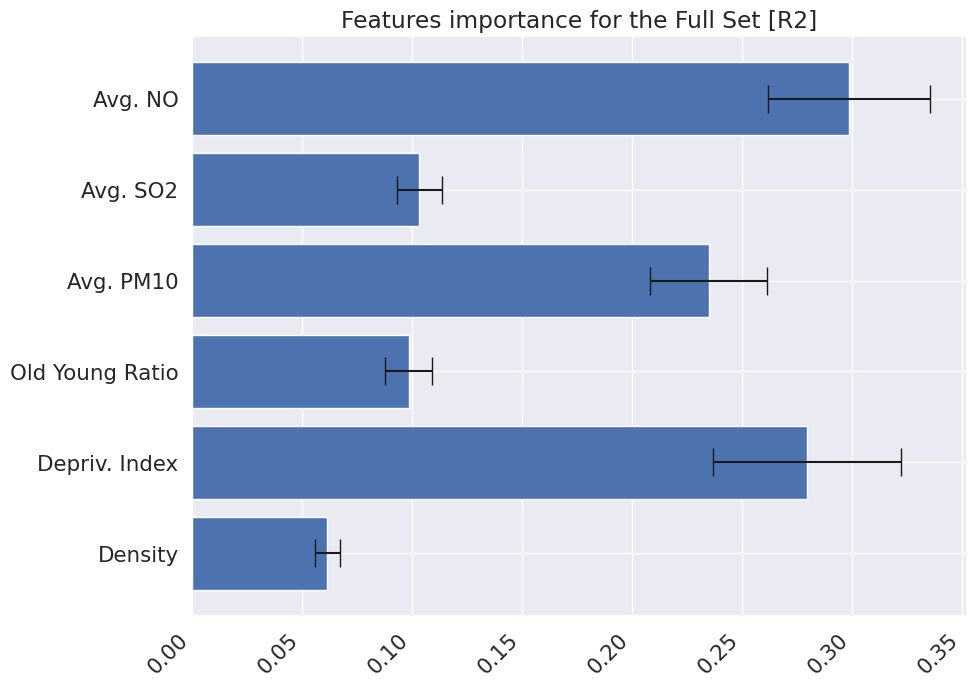

<Figure size 1000x1000 with 0 Axes>

         Trainingset RMSE:    0.36179
                       R2:    0.93746


<Figure size 640x480 with 0 Axes>

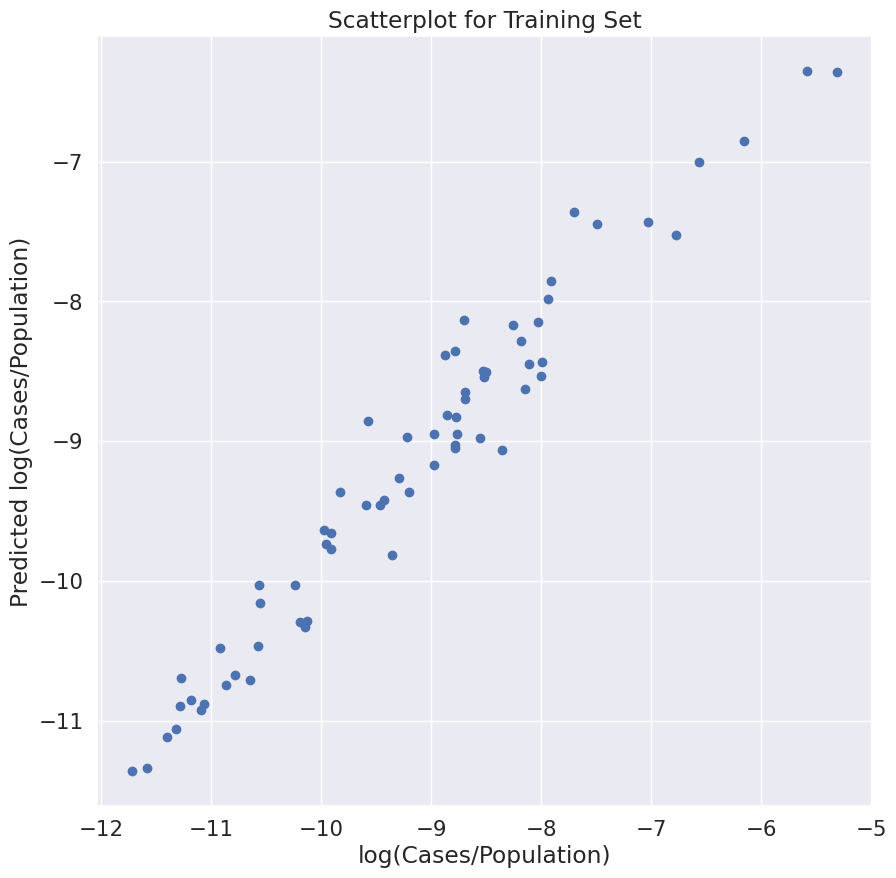

<Figure size 1000x1000 with 0 Axes>

             Testset RMSE:    1.05879
                       R2:    0.43376


<Figure size 640x480 with 0 Axes>

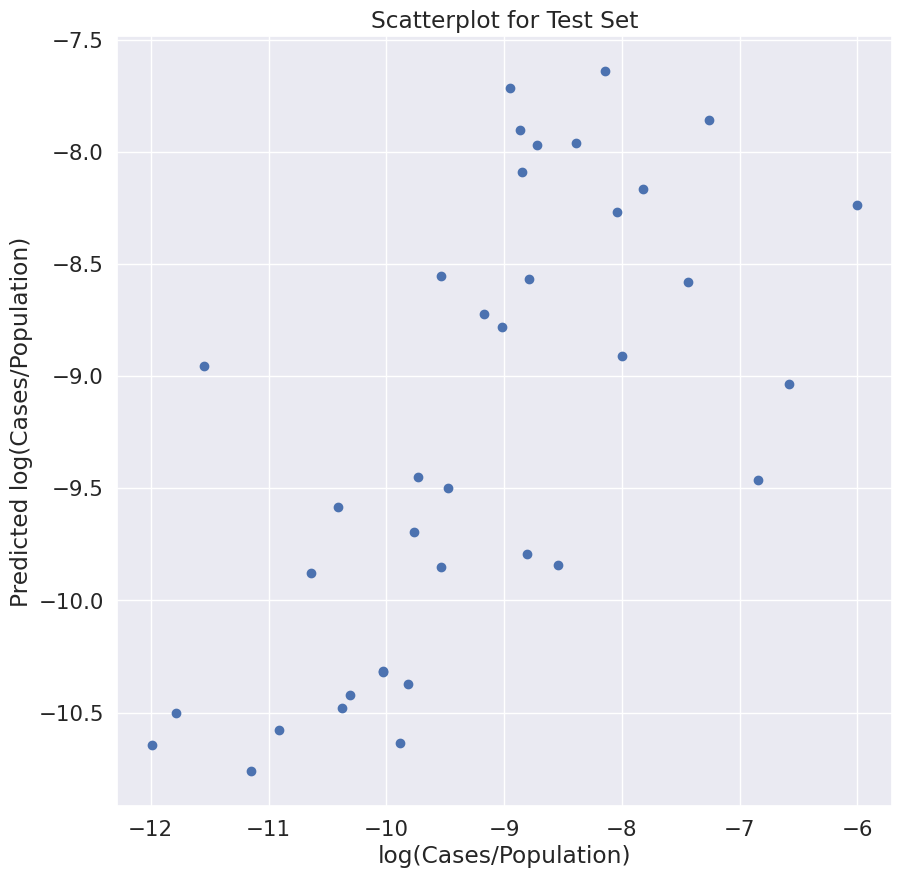

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.02592 +/- 0.04422
Feature:                  Depriv. Index, Score: 0.44933 +/- 0.20526
Feature:                Old Young Ratio, Score: 0.00522 +/- 0.05176
Feature:                      Avg. PM10, Score: 0.09352 +/- 0.06898
Feature:                       Avg. SO2, Score: 0.04160 +/- 0.03923
Feature:                        Avg. NO, Score: 0.31545 +/- 0.15534


<Figure size 640x480 with 0 Axes>

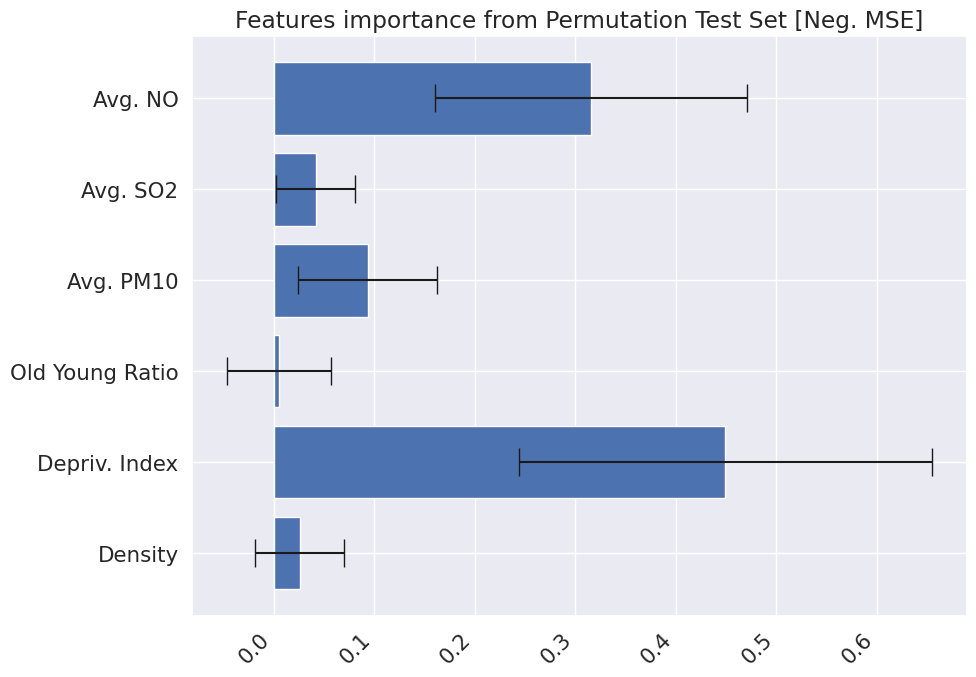

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.01309 +/- 0.02233
Feature:                  Depriv. Index, Score: 0.22696 +/- 0.10368
Feature:                Old Young Ratio, Score: 0.00264 +/- 0.02614
Feature:                      Avg. PM10, Score: 0.04724 +/- 0.03484
Feature:                       Avg. SO2, Score: 0.02101 +/- 0.01982
Feature:                        Avg. NO, Score: 0.15933 +/- 0.07846


<Figure size 640x480 with 0 Axes>

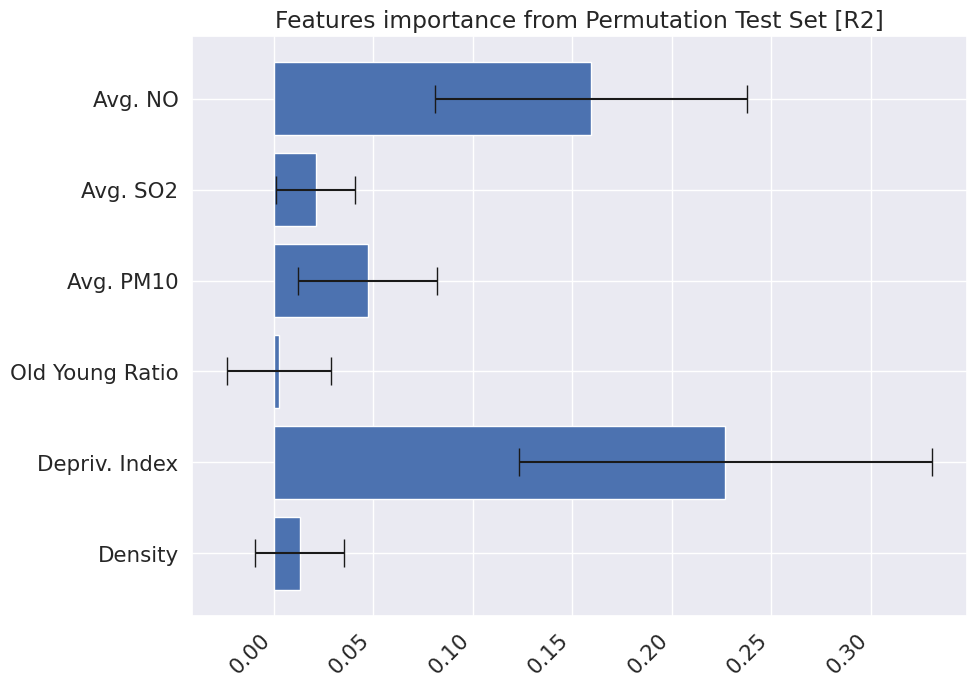

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.15437 +/- 0.02230
Feature:                  Depriv. Index, Score: 0.73967 +/- 0.11378
Feature:                Old Young Ratio, Score: 0.21868 +/- 0.03249
Feature:                      Avg. PM10, Score: 0.27035 +/- 0.04501
Feature:                       Avg. SO2, Score: 0.15701 +/- 0.01866
Feature:                        Avg. NO, Score: 0.63670 +/- 0.10667


<Figure size 640x480 with 0 Axes>

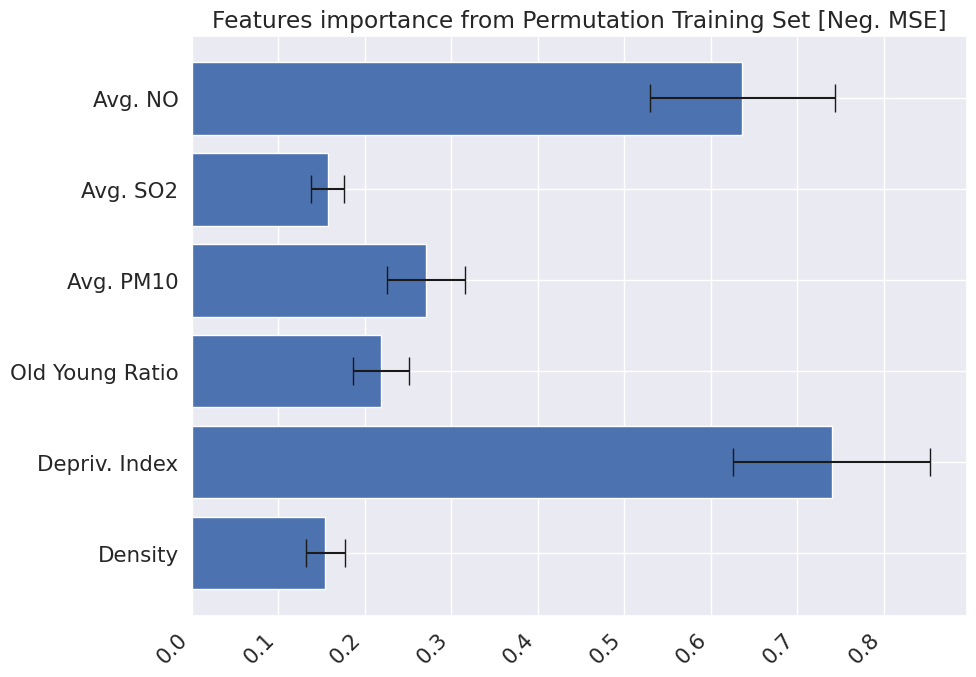

<Figure size 1000x1000 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.07376 +/- 0.01065
Feature:                  Depriv. Index, Score: 0.35341 +/- 0.05436
Feature:                Old Young Ratio, Score: 0.10448 +/- 0.01552
Feature:                      Avg. PM10, Score: 0.12917 +/- 0.02151
Feature:                       Avg. SO2, Score: 0.07502 +/- 0.00892
Feature:                        Avg. NO, Score: 0.30421 +/- 0.05096


<Figure size 640x480 with 0 Axes>

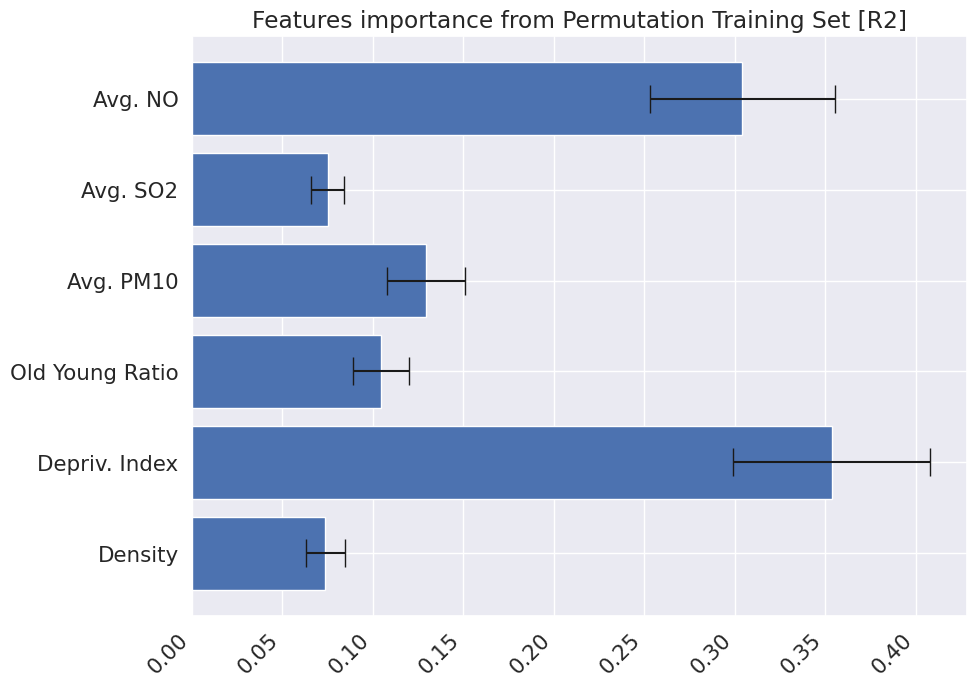

<Figure size 1000x1000 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 1}


In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.32827 +/-  0.02152 
    Test set average RMSE:  0.90826 +/-  0.09950 
  Training set average R2:  0.94675 +/-  0.00530 
      Test set average R2:  0.58235 +/-  0.07213 
Taining:
             Density ,    0.07338 +/-    0.01246 ,   -0.00882 +/-    0.01159 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.00000
        Com. Density ,    0.23321 +/-    0.04151 ,    0.05257 +/-    0.02995 ,    0.00000 ,   61.00000 ,    0.00000 ,   72.50000
       Depriv. Index ,    0.14550 +/-    0.02875 ,    0.02043 +/-    0.01789 ,    0.00000 ,    1.00000 ,    0.00000 ,    4.50000
            Latitude ,    0.69036 +/-    0.08951 ,    0.27834 +/-    0.04987 ,  100.00000 ,    0.00000 ,  100.00000 ,    0.00000
     Old Young Ratio ,    0.10655 +/-    0.02353 ,    0.00498 +/-    0.01608 ,    0.00000 ,    0.00000 ,    0.00000 ,    2.00000
           Avg. PM10 ,    0.17529 +/-    0.04347 ,    0

<Figure size 1000x1000 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800,
 'random_state': 1}


In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.35918 +/-  0.02306 
    Test set average RMSE:  0.97735 +/-  0.10522 
  Training set average R2:  0.93641 +/-  0.00669 
      Test set average R2:  0.51024 +/-  0.11162 
Taining:
             Density ,    0.07268 +/-    0.01993 ,   -0.00181 +/-    0.01520 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.00000
        Com. Density ,    1.48899 +/-    0.43725 ,    0.56051 +/-    0.15179 ,   96.50000 ,    3.50000 ,  100.00000 ,    0.00000
       Depriv. Index ,    0.10737 +/-    0.04686 ,    0.01285 +/-    0.02069 ,    0.50000 ,    1.50000 ,    0.00000 ,    1.00000
     Old Young Ratio ,    0.21616 +/-    0.07767 ,    0.04284 +/-    0.03454 ,    0.00000 ,   15.50000 ,    0.00000 ,   23.00000
           Avg. PM10 ,    0.21714 +/-    0.11199 ,    0.03102 +/-    0.03854 ,    0.00000 ,   21.50000 ,    0.00000 ,   16.00000
            Avg. SO2 ,    0.09574 +/-    0.03291 ,    0

<Figure size 1000x1000 with 0 Axes>

In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 1}


In [17]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.37397 +/-  0.02281 
    Test set average RMSE:  1.01958 +/-  0.10319 
  Training set average R2:  0.93029 +/-  0.00685 
      Test set average R2:  0.48518 +/-  0.08928 
Taining:
             Density ,    0.13186 +/-    0.02532 ,    0.00279 +/-    0.01693 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.00000
       Depriv. Index ,    0.52767 +/-    0.11417 ,    0.18596 +/-    0.04029 ,   31.50000 ,   45.50000 ,   53.50000 ,   43.50000
     Old Young Ratio ,    0.19317 +/-    0.03915 ,    0.01549 +/-    0.02267 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.00000
           Avg. PM10 ,    0.40689 +/-    0.11161 ,    0.09604 +/-    0.04344 ,    7.00000 ,   22.00000 ,    0.50000 ,    8.50000
            Avg. SO2 ,    0.17818 +/-    0.03670 ,    0.02628 +/-    0.01813 ,    0.00000 ,    0.00000 ,    0.00000 ,    1.00000
             Avg. NO ,    0.61141 +/-    0.14429 ,    0

<Figure size 1000x1000 with 0 Axes>